<a href="https://colab.research.google.com/github/ElafNawaf/wallet/blob/main/hypothesis_testing_percentiles_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis Testing & Percentiles – Modular Notebook Template

This notebook is designed so **each participant** can plug in their own case:

- Choose a dataset (full-stack CTR, observability, capital projects, bank fraud, or your own).
- Define **assumptions**: previous/baseline mean, acceptable alpha, and tail type.
- Run **hypothesis tests** (z-style, using a normal approximation).
- Compute **percentiles** and think about **corrective action rules**.

You only need to **edit the configuration cells** (marked like this `# <<< EDIT HERE`).


In [1]:
# === 0. Imports ===
import numpy as np
import pandas as pd
from math import erf, sqrt
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Helper: standard normal CDF (no external libraries needed)
def norm_cdf(z: float) -> float:
    """Return Phi(z) for standard normal using error function."""
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

# Set display options
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load a dataset

You can use one of the provided CSVs (from Bassam's synthetic data), or your own:

- `fullstack_ctr_dataset.csv` – full‑stack CTR A/B sessions  
- `observability_login_dataset.csv` – login errors & latency per minute  
- `capital_projects_dataset.csv` – project delays & cost overruns  
- `bank_fraud_dataset.csv` – transactions & fraud flags  

**Edit the path below** to point to the dataset you want to explore.


In [3]:
# === 1A. Choose which CSV to load ===
# <<< EDIT HERE: set the path to the CSV you want to use >>>
DATASET_PATH = "fullstack_ctr_dataset.csv"  # e.g. "observability_login_dataset.csv"

In [4]:
df = pd.read_csv(DATASET_PATH)
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (1000, 7)


,session_id,user_segment,device,version,impressions,clicks,ctr
0,1,returning,mobile,A,18,2,0.111111
1,2,returning,mobile,B,11,0,0.000000
2,3,returning,mobile,A,35,1,0.028571
3,4,returning,mobile,A,38,1,0.026316
4,5,new,mobile,B,41,4,0.097561


## 2. Explore the dataset

Use this section to understand what columns exist and which one you want to test:

- Which column will be your **metric**? (e.g. `ctr`, `error_rate`, `delay_days`, `amount_sar`)
- Do you want to filter to a **subset**? (e.g. only `"new"` deployment, or a single contractor)


In [5]:
# === 2A. Basic dataset overview ===
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMissing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  None ✓")

# Identify column types automatically
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Also check for low-cardinality numeric columns that might be categorical
for col in numeric_cols:
    if df[col].nunique() <= 10 and df[col].nunique() < len(df) * 0.1:
        # Low cardinality, might be categorical
        categorical_cols.append(col)
        numeric_cols.remove(col)

print(f"\n Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f" Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Summary statistics
print("\n" + "=" * 60)
print("NUMERIC SUMMARY STATISTICS")
print("=" * 60)
if numeric_cols:
    print(df[numeric_cols].describe().transpose())
else:
    print("  No numeric columns found.")


DATASET OVERVIEW
Shape: 1000 rows × 7 columns

Columns: ['session_id', 'user_segment', 'device', 'version', 'impressions', 'clicks', 'ctr']

Missing values:
  None ✓

 Numeric columns (3): ['session_id', 'impressions', 'ctr']
 Categorical columns (4): ['user_segment', 'device', 'version', 'clicks']

NUMERIC SUMMARY STATISTICS
              count        mean         std   min     25%         50%  \
session_id   1000.0  500.500000  288.819436   1.0  250.75  500.500000   
impressions  1000.0   30.024000   11.611126  10.0   20.00   31.000000   
ctr          1000.0    0.032017    0.035490   0.0    0.00    0.026316   

                    75%          max  
session_id   750.250000  1000.000000  
impressions   40.000000    50.000000  
ctr            0.051619     0.217391  


In [6]:
# === 2B. Categorical variable analysis ===
print("=" * 60)
print("CATEGORICAL VARIABLE ANALYSIS")
print("=" * 60)

if categorical_cols:
    for col in categorical_cols:
        print(f"\n {col.upper()}")
        print("-" * 40)
        value_counts = df[col].value_counts()
        print(value_counts)

        # Calculate percentages
        print("\nPercentages:")
        percentages = df[col].value_counts(normalize=True) * 100
        for val, pct in percentages.items():
            print(f"  {val}: {pct:.2f}%")
else:
    print("  No categorical columns found.")


CATEGORICAL VARIABLE ANALYSIS

 USER_SEGMENT
----------------------------------------
user_segment
returning    598
new          402
Name: count, dtype: int64

Percentages:
  returning: 59.80%
  new: 40.20%

 DEVICE
----------------------------------------
device
mobile     686
desktop    314
Name: count, dtype: int64

Percentages:
  mobile: 68.60%
  desktop: 31.40%

 VERSION
----------------------------------------
version
A    524
B    476
Name: count, dtype: int64

Percentages:
  A: 52.40%
  B: 47.60%

 CLICKS
----------------------------------------
clicks
0    407
1    335
2    171
3     61
4     17
5      6
6      2
7      1
Name: count, dtype: int64

Percentages:
  0: 40.70%
  1: 33.50%
  2: 17.10%
  3: 6.10%
  4: 1.70%
  5: 0.60%
  6: 0.20%
  7: 0.10%


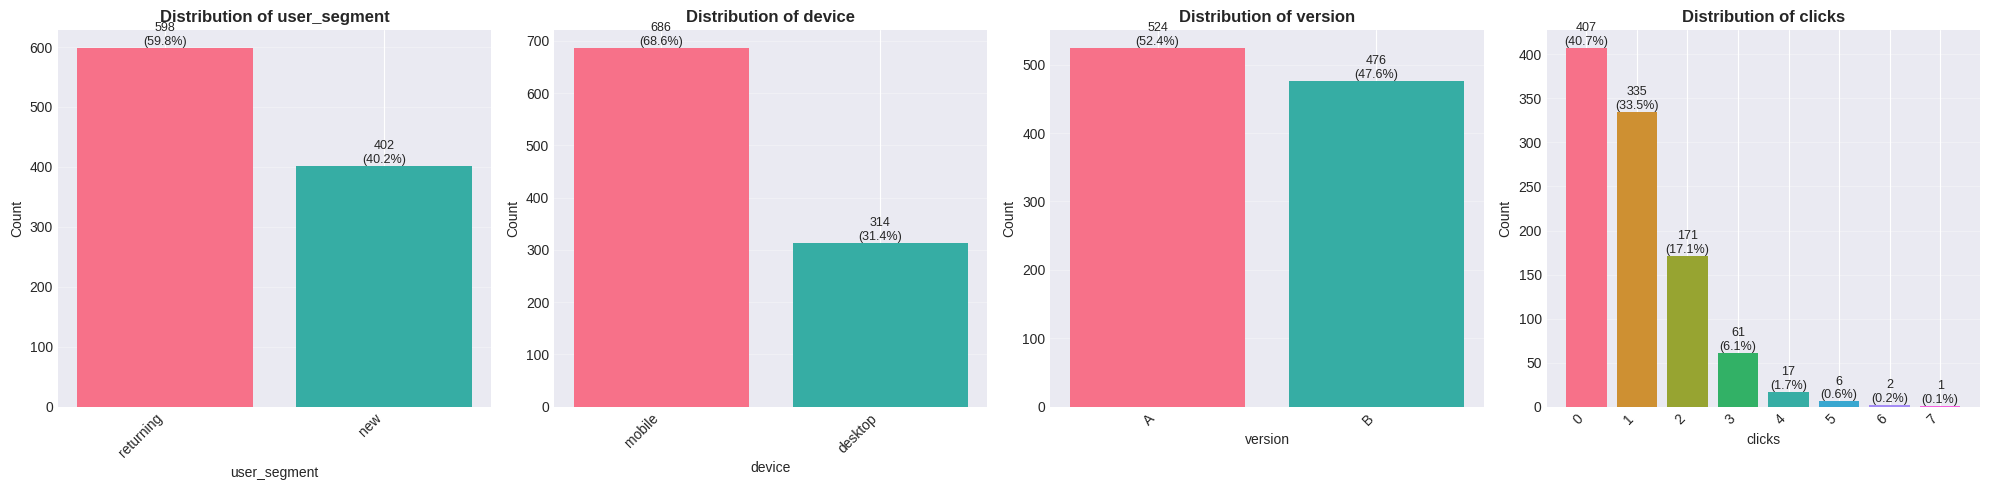

In [7]:
# === 2C. Visualizations: Categorical Variables ===
if categorical_cols:
    n_cat = len(categorical_cols)
    fig, axes = plt.subplots(1, min(n_cat, 4), figsize=(5 * min(n_cat, 4), 5))

    if n_cat == 1:
        axes = [axes]

    for idx, col in enumerate(categorical_cols[:4]):  # Limit to 4 for readability
        ax = axes[idx] if n_cat > 1 else axes[0]
        value_counts = df[col].value_counts()

        # Create bar plot
        bars = ax.bar(range(len(value_counts)), value_counts.values,
                     color=sns.color_palette("husl", len(value_counts)))
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
        ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, value_counts.values)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val}\n({val/len(df)*100:.1f}%)',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("No categorical variables to visualize.")


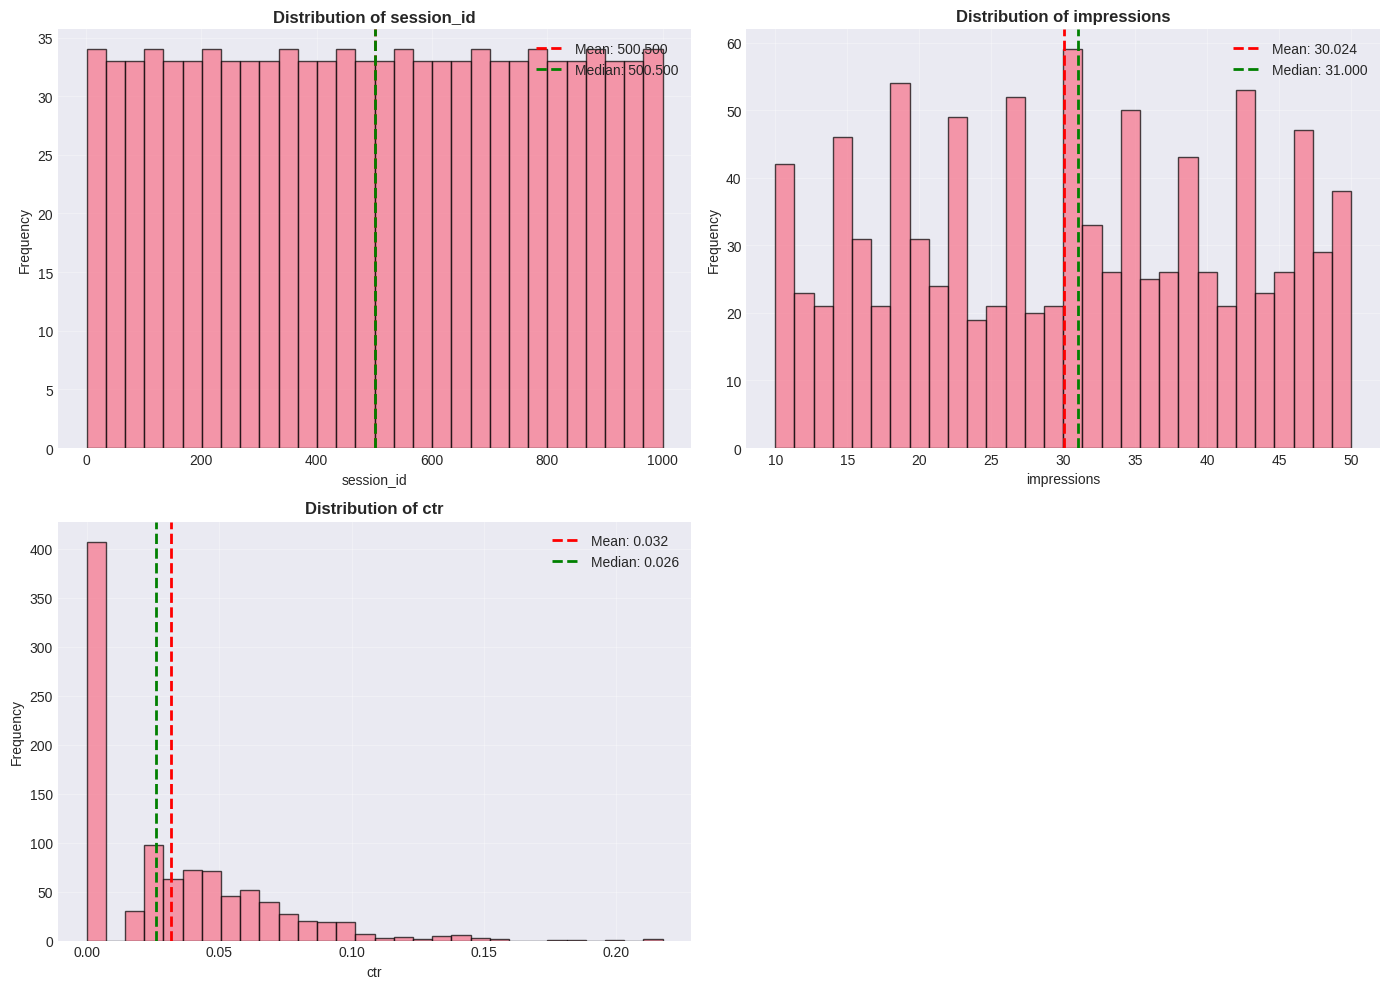

In [8]:
# === 2D. Visualizations: Numeric Variables ===
if numeric_cols:
    n_num = len(numeric_cols)
    # Create subplots: 2 columns, adjust rows as needed
    n_rows = (n_num + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))

    if n_num == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, col in enumerate(numeric_cols):
        ax = axes[idx]

        # Histogram with KDE
        df[col].hist(bins=30, ax=ax, alpha=0.7, edgecolor='black')
        ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {df[col].mean():.3f}')
        ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2,
                  label=f'Median: {df[col].median():.3f}')
        ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(alpha=0.3)

    # Hide unused subplots
    for idx in range(n_num, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No numeric variables to visualize.")


/tmp/ipython-input-2980027993.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=groups, patch_artist=True)
/tmp/ipython-input-2980027993.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=groups, patch_artist=True)
/tmp/ipython-input-2980027993.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=groups, patch_artist=True)


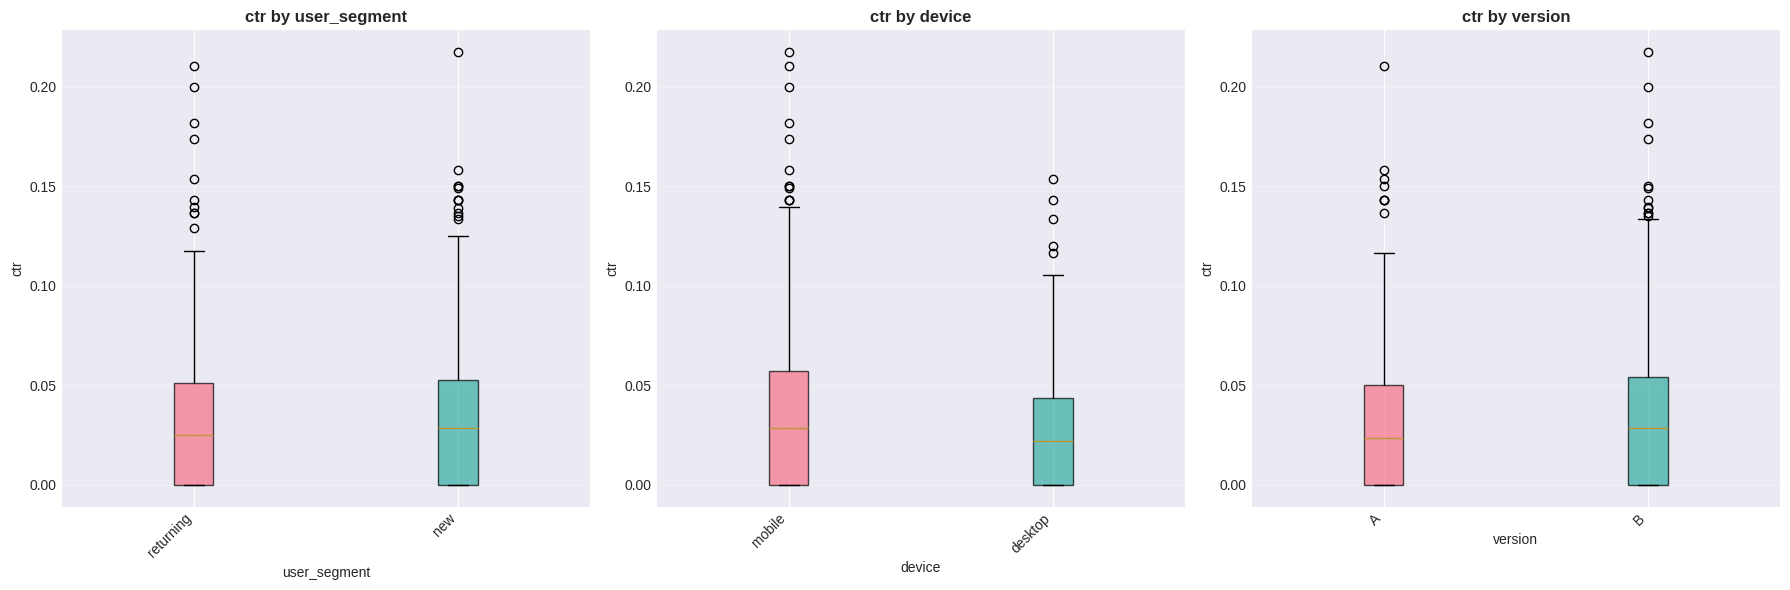

In [9]:
# === 2E. Box plots: Numeric variables by categorical groups ===
# This helps understand how numeric metrics vary across categorical groups

if numeric_cols and categorical_cols:
    # Find the main metric column (usually the last numeric or one with 'rate', 'ctr', etc.)
    # Or use the first numeric column as default
    metric_col = None
    for col in numeric_cols:
        if any(keyword in col.lower() for keyword in ['rate', 'ctr', 'metric', 'value', 'amount']):
            metric_col = col
            break
    if metric_col is None and numeric_cols:
        metric_col = numeric_cols[0]

    if metric_col:
        n_cat = len(categorical_cols)
        fig, axes = plt.subplots(1, min(n_cat, 3), figsize=(6 * min(n_cat, 3), 6))

        if n_cat == 1:
            axes = [axes]

        for idx, cat_col in enumerate(categorical_cols[:3]):  # Limit to 3 for readability
            ax = axes[idx] if n_cat > 1 else axes[0]

            # Create box plot
            groups = df[cat_col].unique()
            data_to_plot = [df[df[cat_col] == group][metric_col].dropna() for group in groups]

            bp = ax.boxplot(data_to_plot, labels=groups, patch_artist=True)

            # Color the boxes
            colors = sns.color_palette("husl", len(groups))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            ax.set_title(f'{metric_col} by {cat_col}', fontsize=12, fontweight='bold')
            ax.set_xlabel(cat_col)
            ax.set_ylabel(metric_col)
            ax.grid(axis='y', alpha=0.3)
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
else:
    print("Need both numeric and categorical columns for comparison plots.")


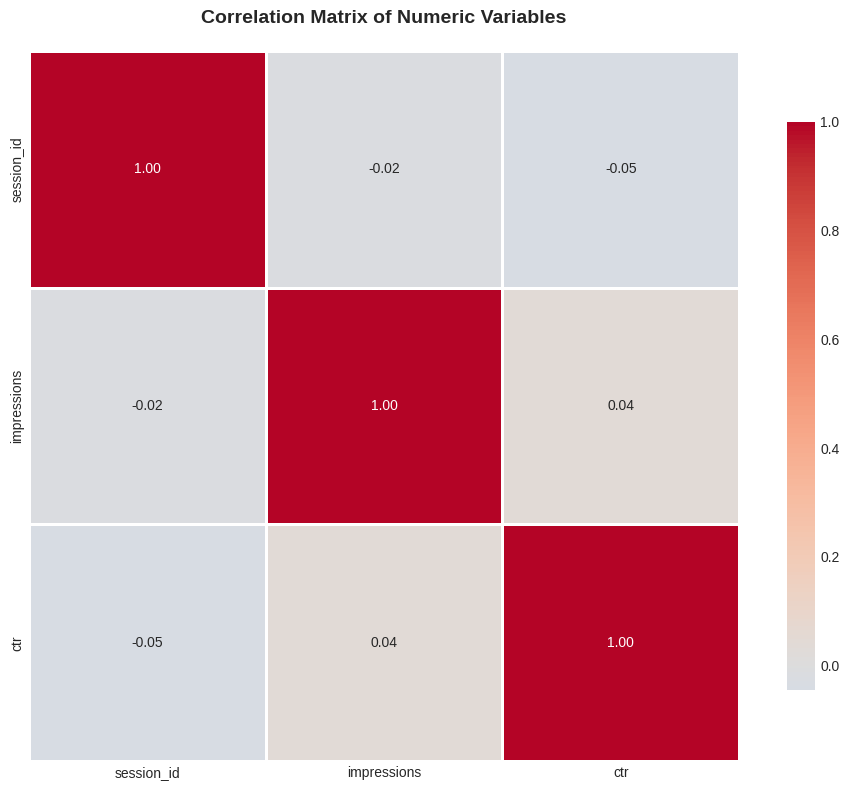

In [10]:
# === 2F. Correlation heatmap (if multiple numeric variables) ===
if len(numeric_cols) > 1:
    fig, ax = plt.subplots(figsize=(10, 8))

    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Create heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title('Correlation Matrix of Numeric Variables', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()
else:
    print("Need at least 2 numeric variables for correlation analysis.")


## 3. One-sample z-style test (mean) – generic module

Use this when you have:

- A **sample** from your current data (e.g. new version / new contractor / after policy).
- A **previous or target mean** from historical data, domain knowledge, or regulation.
- An assumed **population standard deviation** (σ). If you don't have it, you may **approximate** with the sample std.

You'll define:

- `METRIC_COL` → which numeric column to test (e.g. `ctr`, `error_rate`, `delay_days`).  
- `SAMPLE_FILTER` → condition to select the current sample.  
- `PREVIOUS_MEAN` (μ₀) → your baseline/target.  
- `ASSUMED_SIGMA` (σ) → assumed population std (or reasonable approximation).  
- `ALPHA` → significance level (e.g. 0.05).  
- `TAIL` → `"greater"`, `"less"`, or `"two-sided"`.


In [11]:
# === 3A. Configure your one-sample test ===
# <<< EDIT HERE >>>

# 1) Which numeric metric are you testing?
METRIC_COL = "ctr"  # e.g. "error_rate", "delay_days", "amount_sar"

# 2) Define a filter for your sample (Boolean mask)
#    Examples:
#    - df["version"] == "B"
#    - df["deployment"] == "new"
#    - df["contractor"] == "A"
#    - df["period"] == "after_policy"
SAMPLE_FILTER = df["version"] == "B"  # <<< adjust to your case

# 3) Define your prior/baseline assumptions
PREVIOUS_MEAN = 0.03   # μ0 (e.g. historical CTR, baseline error rate)
ASSUMED_SIGMA = 0.01   # σ (e.g. known or approximate std dev of the metric)
ALPHA = 0.05           # acceptable alpha (type I error)

# "greater"  : H1: μ > μ0  (e.g. CTR increased, error got worse)
# "less"     : H1: μ < μ0  (e.g. delay decreased)
# "two-sided": H1: μ ≠ μ0
TAIL = "greater"


In [12]:
# === 3B. Run the one-sample z-style test ===

sample = df.loc[SAMPLE_FILTER, METRIC_COL].dropna()

n = sample.shape[0]
sample_mean = sample.mean()

if n == 0:
    raise ValueError("Your SAMPLE_FILTER selected zero rows. Adjust it and rerun.")

se = ASSUMED_SIGMA / np.sqrt(n)  # standard error
z_stat = (sample_mean - PREVIOUS_MEAN) / se

# Compute p-value based on tail choice
if TAIL == "greater":
    p_value = 1 - norm_cdf(z_stat)
elif TAIL == "less":
    p_value = norm_cdf(z_stat)
elif TAIL == "two-sided":
    p_value = 2 * (1 - norm_cdf(abs(z_stat)))
else:
    raise ValueError("TAIL must be 'greater', 'less', or 'two-sided'.")

print(f"Metric column      : {METRIC_COL}")
print(f"Sample size (n)    : {n}")
print(f"Sample mean        : {sample_mean:.6f}")
print(f"Baseline mean (μ0) : {PREVIOUS_MEAN:.6f}")
print(f"Assumed σ          : {ASSUMED_SIGMA:.6f}")
print(f"Standard error     : {se:.6f}")
print(f"z-statistic        : {z_stat:.3f}")
print(f"p-value            : {p_value:.4g}")
print(f"Alpha              : {ALPHA}")

if p_value < ALPHA:
    print("\n✅ Result: Reject H0 (statistically significant difference).")
else:
    print("\n❌ Result: Do NOT reject H0 (no statistically significant evidence).")


Metric column      : ctr
Sample size (n)    : 476
Sample mean        : 0.034739
Baseline mean (μ0) : 0.030000
Assumed σ          : 0.010000
Standard error     : 0.000458
z-statistic        : 10.339
p-value            : 0
Alpha              : 0.05

✅ Result: Reject H0 (statistically significant difference).


## 4. Percentiles & corrective action – generic module

Use this to:

- Compute **distribution cut points** (p50, p75, p90, p95, p99) for a metric.
- Decide what “normal” vs “extreme” looks like.
- Design simple **rules** like “if current value > baseline p90 → alert”.

Typical metrics:

- Latency (`p95_latency_ms`)
- Error rate (`error_rate`)
- Delay (`delay_days`)
- Cost overrun (`cost_overrun_pct`)
- Amount (`amount_sar`)


In [13]:
# === 4A. Configure percentile analysis ===
# <<< EDIT HERE >>>

PERC_METRIC_COL = METRIC_COL  # reuse, or set explicitly e.g. "p95_latency_ms"

# Define which rows represent your "healthy baseline" period.
# Examples:
#   df["deployment"] == "old"
#   df["version"] == "A"
#   df["period"] == "before_policy"
BASELINE_FILTER = df["version"] == "A"  # <<< adjust to your case

baseline_series = df.loc[BASELINE_FILTER, PERC_METRIC_COL].dropna()

if baseline_series.shape[0] == 0:
    raise ValueError("Your BASELINE_FILTER selected zero rows. Adjust it and rerun.")

percentiles_to_compute = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
perc_values = baseline_series.quantile(percentiles_to_compute)
perc_values


,ctr
0.25,0.000000
0.50,0.023810
0.75,0.050321
0.90,0.072648
0.95,0.086957
0.99,0.142857


### 4B. Interpreting percentiles

- p50 (0.50) → 50% of baseline values are **≤ this value**.  
- p90 (0.90) → 90% are **≤ this value**, 10% are higher.  
- p99 (0.99) → 99% are **≤ this value**, 1% are higher (extreme tail).

**Exercise for you / your group:**  
- Based on the printed percentile values above, write down 2–3 **rules** such as:
  - “If today’s p95 latency > baseline p90 → send warning.”  
  - “If contractor’s median delay > baseline p75 → put on watchlist.”  
  - “If transaction amount > customer’s p99 → step-up authentication.”


## 5. (Optional) From stats to ML

Use this space to:

- Create **features** from these metrics and percentiles (e.g. `is_above_p90`, `metric_minus_p50`).
- Train a simple **model** (regression/classification) if you want to connect to ML.

⚠️ This notebook intentionally does **not** include ML code yet, so it stays focused on:

- Clear assumptions (μ₀, α, tail)  
- Hypothesis testing logic  
- Percentile-based thinking for corrective actions

You can add your preferred ML library (scikit-learn, XGBoost, etc.) below if needed.


In [14]:
# === 5A. Example: create a simple percentile-based flag feature (optional) ===
# This is just a placeholder example.
# You can build on this for your own ML experiments.

# Suppose we use the baseline p90 as a threshold:
p90_value = baseline_series.quantile(0.9)

df[f"{PERC_METRIC_COL}_above_p90_baseline"] = df[PERC_METRIC_COL] > p90_value
df[[PERC_METRIC_COL, f"{PERC_METRIC_COL}_above_p90_baseline"]].head()


,ctr,ctr_above_p90_baseline
0,0.111111,True
1,0.000000,False
2,0.028571,False
3,0.026316,False
4,0.097561,True
